
# I- Contrastive loss for MNIST



### Imports

In [100]:
from mnist_utils import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Lambda,Flatten,MaxPooling2D,Dropout,Conv2D 

In [108]:
exec(open('mnist_utils.py').read())

    
## 1- Prepare train and test 

In [7]:
train_images,train_labels,test_images,test_labels = load_MNIST_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
### all_train[i] contains all train images of class i
all_train, all_test = data_groupby_class(train_images,train_labels,test_images,test_labels)

In [9]:
# shape = (nb_samples,sample_size)
all_train[9].shape

(5949, 784)

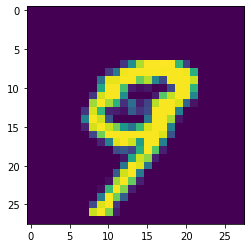

In [10]:
plt.imshow(all_train[9][10,].reshape(28,28))

Let's only consider examples of classes 0,1,2,3,4 for training our network using contrastive loss



###Prepare pairs of examples for training, keep only classes 0 to 4 

In [11]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same,labels_same = prepare_same_pairs(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs(all_train,n_pairs_diff,'train')

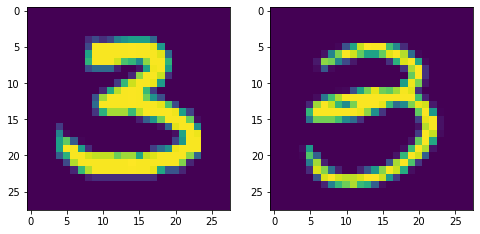

In [12]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_same[20,:,0].reshape(28,28))
fig.add_subplot(1,2,2)
plt.imshow(pairs_same[20,:,1].reshape(28,28))

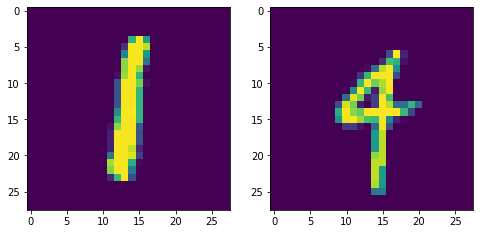

In [13]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_diff[20,:,0].reshape(28,28))
fig.add_subplot(1,2,2)
plt.imshow(pairs_diff[20,:,1].reshape(28,28))

create y such as equals 1 if pairs are from the same class, 0 otherwise :

In [14]:
y = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x = np.concatenate([pairs_same, pairs_diff], axis = 0)

## 2- Build the  first MLP model WITHOUT CLASSES 5 to 9

### 2-1 Prepare the data and build the model

In [15]:
x_train, y_train = shuffle(x, y, random_state=0)

In [16]:
x_train.shape,y_train.shape

((3000, 784, 2), (3000,))

In [17]:
''' build the model of the neural network with is going to 
do the transformation of the samples features x ==> h(x)'''
def build_model_base(input_shape,dropout_rate):
  input = Input(shape=input_shape)
  seq = Sequential()
  seq.add(Dense(128, activation='relu'))
  seq.add(Dropout(dropout_rate))
  seq.add(Dense(60, activation='relu'))
  seq.add(Dropout(dropout_rate))
  seq.add(Dense(20, activation='relu'))
  return seq

### 2-1-train and test the model

In [18]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 256
dropout_rate = 0.2

### model
input_shape = x_train.shape[1]

base_network = build_model_base(input_shape,dropout_rate)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network(branch1)
processed2 = base_network(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
model.fit([x_train[:,:, 0], x_train[:,:, 1]], y_train, batch_size=batch_size, epochs=nb_epochs)

pred_train = model.predict([x_train[:,:,0], x_train[:,:,1]])
## We choose an arbitrary threshhold of 0.5
acc = compute_accuracy(pred_train, y_train,0.5)
print(acc)

Epoch 1/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2682
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2137
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1828
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1583
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1387
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1245
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1139
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1010
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0851
0.979


In [19]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same_test,labels_same_test = prepare_same_pairs(all_test,n_pairs_same,'test')
pairs_diff_test,labels_diff_test = prepare_different_pairs(all_test,n_pairs_diff,'test')

y_test = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test, y_test = shuffle(x_test, y_test, random_state=0)

pred_test = model.predict([x_test[:,:,0], x_test[:,:,1]])
acc = compute_accuracy(pred_test, y_test,0.5)
print(acc)

0.7783333333333333


### 2-2- Check embeddings learned for the test set 

In [20]:
encodings = base_network.predict(test_images)

In [21]:
## (nb_test_samples, dimension of encodings)
encodings.shape

(10000, 20)

In [22]:
pca , transformed_encodings = fitting_pca(encodings,nb_components = 2)
pca.explained_variance_ratio_.sum() * 100

73.25893640518188

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



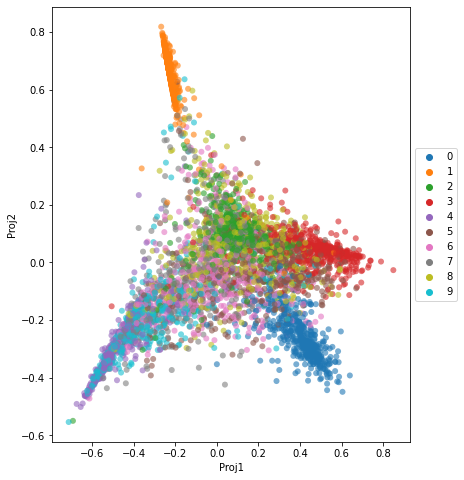

In [23]:
transformed_encodings_plot_2d(transformed_encodings[:5000],test_labels[:5000])

### 2-3- Impact of the choice of the  threshhold 

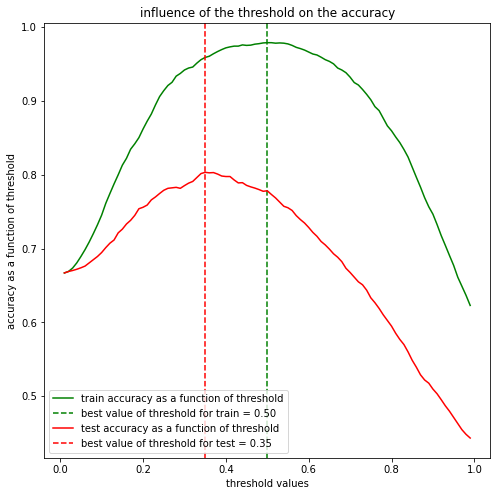

In [24]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train)

In [25]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.979
test accuracy of our best first model =  0.8033333333333333
best threshold is  0.35000000000000003


## 2- Build the second MLP model with classes 5 to 9

Let's add One example for class 5, one example for class 6, one example for class 7, one example for class 7, one example for class 8 and one example for class 9 in the training set  and then let's see if the model is capable of distinguishing these new classes 

### 2-1- Prepare the data, define the model, train and test It

In [26]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same,labels_same = prepare_same_pairs2(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs2(all_train,n_pairs_diff,'test')

y2 = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x2 = np.concatenate([pairs_same, pairs_diff], axis = 0)

x_train2, y_train2 = shuffle(x2, y2, random_state=0)

Define the same model and train It 

In [27]:
### hyperparameters of the model
nb_epochs = 10 
batch_size = 256
dropout_rate = 0.2

### model
input_shape = x_train2.shape[1]

base_network = build_model_base(input_shape,dropout_rate)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network(branch1)
processed2 = base_network(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
model.fit([x_train2[:,:, 0], x_train2[:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs)

pred_train = model.predict([x_train2[:,:,0], x_train2[:,:,1]])
## We choose an arbitrary threshhold of 0.5
acc = compute_accuracy(pred_train, y_train2,0.5)
print(acc)

Epoch 1/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2496
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1967
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1657
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1444
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1286
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1153
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1059
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0938
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0893
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0794
0.9546666666666667


In [28]:

pred_test = model.predict([x_test[:,:,0], x_test[:,:,1]])
acc = compute_accuracy(pred_test, y_test,0.5)
print(acc)

0.784


### 2-2- Check the encodings of the images in the test set 

Let's see if the model encoded the examples for class 5 close to each other in the test set , same goes for 6 to 9

In [29]:
encodings = base_network.predict(test_images) 
pca , transformed_encodings = fitting_pca(encodings,nb_components = 2)
pca.explained_variance_ratio_.sum() * 100

70.07759213447571

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



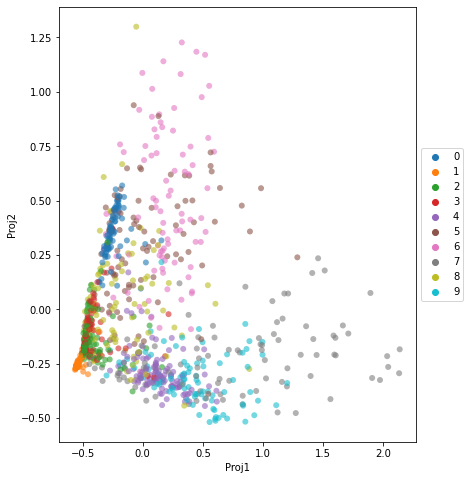

In [30]:
transformed_encodings_plot_2d(transformed_encodings[:1000],test_labels[:1000])

In [31]:
pca , transformed_encodings = fitting_pca(encodings,nb_components = 3)

transformed_encodings_plot_3d(pca,transformed_encodings[:1000],test_labels[:1000])

### 2-3- Impact of the threshold on the accuracy

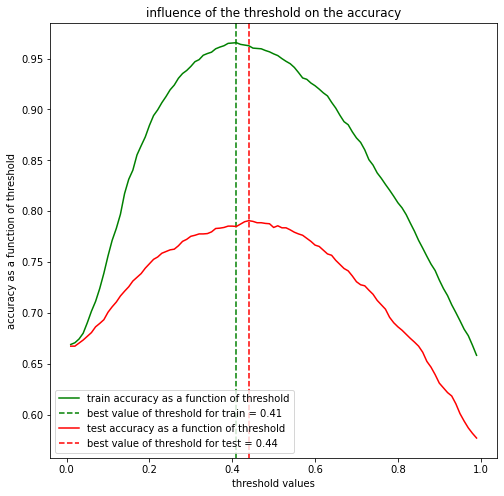

In [32]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train2)

In [33]:
acc_train = compute_accuracy(pred_train, y_train2,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.9656666666666667
test accuracy of our best first model =  0.7906666666666666
best threshold is  0.44


Some pairs that were incorrecty labeled for threshold 0.47

In [34]:
x_test.shape

(3000, 784, 2)

In [35]:
predicted_as_similar = x_test[np.where(pred_test<0.47)[0],:,:]
false_positive = predicted_as_similar[y_test[np.where(pred_test<0.47)[0]]==0,:,:]

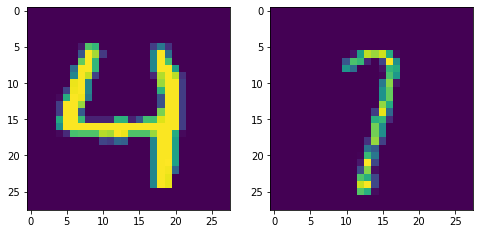

In [36]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(false_positive[2,:,0].reshape(28,28))
fig.add_subplot(1,2,2)
plt.imshow(false_positive[2,:,1].reshape(28,28))

## 3- Build the first CNN model without 5 to 9 classes


### 3-1-Prepare the data

In [37]:
shape = x_train.shape
x_train = x_train.reshape((shape[0],28,28,1,shape[2]))

### 3-2 Build and train the model

In [38]:
def build_model_base2(input_shape,dropout_rate):
  input = Input(shape=input_shape)
  mod = Sequential()
  mod.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  mod.add(MaxPooling2D(pool_size=(2, 2)))
  mod.add(Conv2D(64, (3, 3), activation='relu'))
  mod.add(MaxPooling2D(pool_size=(2, 2)))
  mod.add(Dropout(dropout_rate))
  mod.add(Flatten())
  mod.add(Dense(32, activation='relu'))
  return mod

In [39]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 256

### model
input_shape = x_train.shape[1:4]

base_network_contrastive = build_model_base2(input_shape,0.2)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_contrastive(branch1)
processed2 = base_network_contrastive(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
model.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train, batch_size=batch_size, epochs=nb_epochs)

pred_train = model.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/10
12/12 [==============================] - 0s 17ms/step - loss: 0.1944
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.1193
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0876
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0691
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0579
Epoch 6/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0502
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0442
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0403
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0367
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0339
train accuracy of our model =  0.9913333333333333


In [40]:
test_shape= x_test.shape
x_test = x_test.reshape(test_shape[0],28,28,1,test_shape[2])

pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.847


### 3-3 Impact of the threshhold value on accuracy

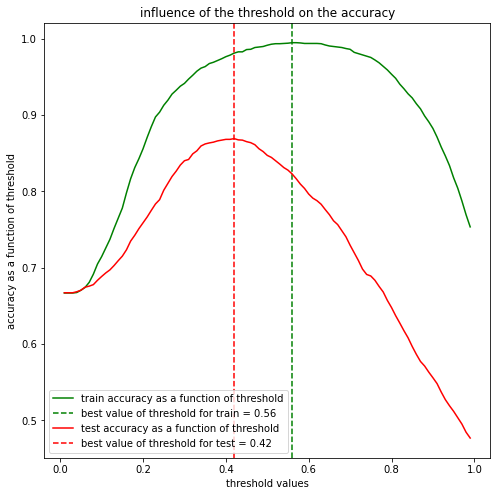

In [41]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train)

In [42]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.9946666666666667
test accuracy of our best first model =  0.869
best threshold is  0.42


## 4- Build the second CNN with classes 5 to 9

### 4-1- Prepare the data

In [43]:
shape = x_train2.shape
x_train2 = x_train2.reshape((shape[0],28,28,1,shape[2]))

### 4-1 Build the model, train and test

In [44]:
### hyperparameters of the model
nb_epochs = 10
batch_size = 256

### model
input_shape = x_train2.shape[1:4]

base_network2 = build_model_base2(input_shape,0.2)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network2(branch1)
processed2 = base_network2(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
model.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs)

pred_train = model.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train2,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/10
12/12 [==============================] - 0s 9ms/step - loss: 0.2083
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.1452
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.1162
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0982
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0839
Epoch 6/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0735
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0656
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0592
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0554
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.0498
train accuracy of our model =  0.9873333333333333


In [45]:
pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.8856666666666667


### 4-2- Impact of the threshold value on the accuracy

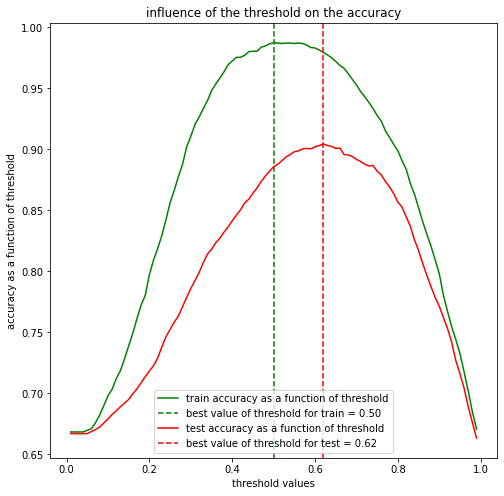

In [46]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train2)

In [47]:
acc_train = compute_accuracy(pred_train, y_train2,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.9873333333333333
test accuracy of our best first model =  0.9043333333333333
best threshold is  0.62


# II- Binary cross entropy for one shot learning

### II-1 test without classes 5 to 9

In [48]:

### hyperparameters of the model
nb_epochs = 10
batch_size = 256

### model
input_shape = x_train.shape[1:4]

base_network_binary = build_model_base2(input_shape,0.5)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_binary(branch1)
processed2 = base_network_binary(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])

prediction = Dense(1,activation='sigmoid')(distance)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
siamese_net.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train, batch_size=batch_size, epochs=nb_epochs)

pred_train = siamese_net.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])


Epoch 1/10
12/12 [==============================] - 0s 9ms/step - loss: 0.6170
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.5509
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.5214
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4933
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4624
Epoch 6/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4272
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4001
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.3658
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.3234
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.2813


In [49]:
acc = compute_accuracy2(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.9146666666666666


In [50]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.7553333333333333


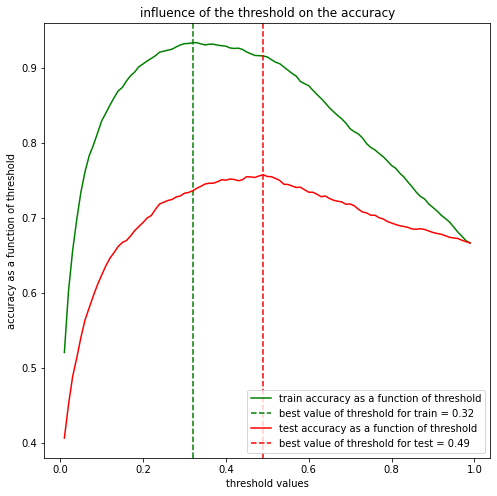

In [51]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train)

### II-2 test with classes 5 to 9

In [52]:

### hyperparameters of the model
nb_epochs = 10
batch_size = 256

### model
input_shape = x_train2.shape[1:4]

base_network2 = build_model_base2(input_shape,0.2)

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network2(branch1)
processed2 = base_network2(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])

prediction = Dense(1,activation='sigmoid')(distance)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
siamese_net.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs)

pred_train = siamese_net.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])


Epoch 1/10
12/12 [==============================] - 0s 10ms/step - loss: 0.6309
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.5629
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.5306
Epoch 4/10
12/12 [==============================] - 0s 9ms/step - loss: 0.5097
Epoch 5/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4920
Epoch 6/10
12/12 [==============================] - 0s 10ms/step - loss: 0.4719
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4526
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4306
Epoch 9/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4073
Epoch 10/10
12/12 [==============================] - 0s 9ms/step - loss: 0.3825


In [53]:
acc = compute_accuracy2(pred_train, y_train2,0.2)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.9096666666666666


In [54]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.2)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.8323333333333334


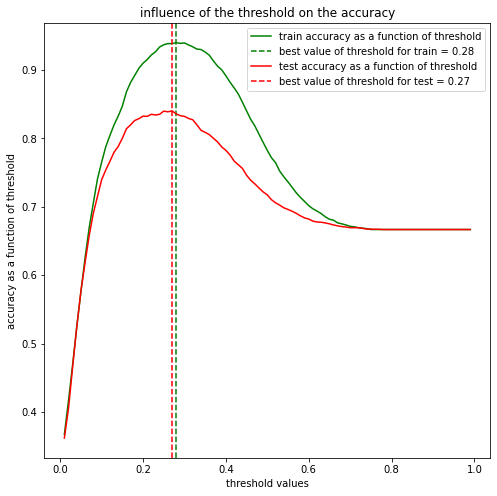

In [55]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train2)

## III- Triplet Loss : 

### III-1- Random choice of triplets , train only on classes 0 to 4 :

### III-1-1 Prepare the data

In [56]:
x = np.concatenate([all_train[0],all_train[1],all_train[2],all_train[3],all_train[4]],axis = 0)
y = np.array([0]*all_train[0].shape[0]+[1]*all_train[1].shape[0]+[2]*all_train[2].shape[0]+[3]*all_train[3].shape[0]+[4]*all_train[4].shape[0])

In [57]:

x,y = shuffle(x, y, random_state=0)

In [58]:
X_train, _ = generate_triplet(x,y, ap_pairs=150, an_pairs=200,testsize=0)
_, X_test = generate_triplet(test_images,test_labels, ap_pairs=30, an_pairs=30,testsize=1)

In [59]:
X_train.shape, X_test.shape

((150000, 3, 784), (9000, 3, 784))

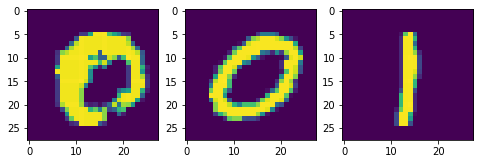

In [60]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_train[index,0,:].reshape(28,28))
fig.add_subplot(1,3,2)
plt.imshow(X_train[index,1,:].reshape(28,28))
fig.add_subplot(1,3,3)
plt.imshow(X_train[index,2,:].reshape(28,28))

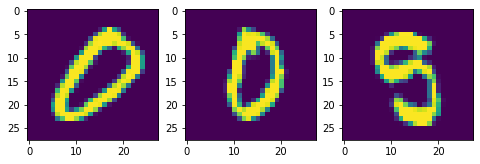

In [61]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_test[index,0,:].reshape(28,28))
fig.add_subplot(1,3,2)
plt.imshow(X_test[index,1,:].reshape(28,28))
fig.add_subplot(1,3,3)
plt.imshow(X_test[index,2,:].reshape(28,28))

#### III-1- 2- Build the model and train It 

In [62]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model_triplet = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet.compile(loss=triplet_loss, optimizer=adam_optim)

In [63]:
model_triplet.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 3)            16547       anchor_input[0][0]               
                                                                 positive_input[0][0] 

In [64]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

model_triplet.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=812, epochs=20)

Epoch 1/20
y_pred.shape =  Tensor("functional_13/merged_layer/concat:0", shape=(None, 9), dtype=float32)
y_pred.shape =  Tensor("functional_13/merged_layer/concat:0", shape=(None, 9), dtype=float32)
185/185 [==============================] - 5s 29ms/step - loss: 0.3533 - val_loss: 0.3268
Epoch 2/20
185/185 [==============================] - 5s 27ms/step - loss: 0.2318 - val_loss: 0.2769
Epoch 3/20
185/185 [==============================] - 5s 27ms/step - loss: 0.1747 - val_loss: 0.2447
Epoch 4/20
185/185 [==============================] - 5s 27ms/step - loss: 0.1321 - val_loss: 0.2192
Epoch 5/20
185/185 [==============================] - 5s 27ms/step - loss: 0.1067 - val_loss: 0.2069
Epoch 6/20
185/185 [==============================] - 5s 27ms/step - loss: 0.0920 - val_loss: 0.2005
Epoch 7/20
185/185 [==============================] - 5s 27ms/step - loss: 0.0819 - val_loss: 0.1968
Epoch 8/20
185/185 [==============================] - 5s 27ms/step - loss: 0.0744 - val_loss: 0.1937
Epoc

### III-1-3- Impact of the threshold on the accuracy

In [65]:
x_test.shape

(3000, 28, 28, 1, 2)

In [66]:
encod1 = Shared_DNN.predict(x_test.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN.predict(x_test.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

In [67]:
distances = np.array(euclidean_distance((encod1, encod2)))

In [68]:
acc = compute_accuracy(distances, y_test,0.5)
print(acc)

0.77


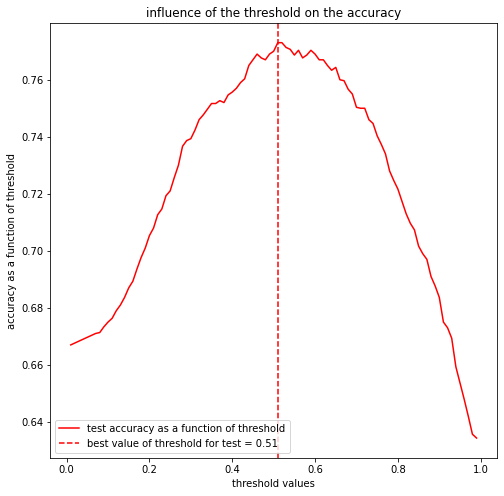

In [69]:
threshold_list = [i*0.01 for i in range (1,100)]
test_acc_list = [compute_accuracy(distances, y_test,threshold) for threshold in threshold_list]
test_index_max = np.argmax(np.array(test_acc_list))

plt.figure(figsize = (8,8))
plt.plot(threshold_list,test_acc_list,label='test accuracy as a function of threshold', c='red')
plt.axvline(x=threshold_list[test_index_max], color='red',linestyle='--',label='best value of threshold for test = {:.2f}'.format(threshold_list[test_index_max]))
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

### VI- Comparison of all the three models trained only on classes  0 to 4

In [70]:
number_of_processes = 10
size_of_encoding_triplet = 3
size_of_encoding_contrastive = 32
size_of_encoding_binary = 32
acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes , 'triplet',size_of_encoding_triplet)
acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes , 'contrastive',size_of_encoding_contrastive)
acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 'binary_crossentropy',size_of_encoding_binary)

In [71]:
acc1[1], acc2[1], acc3[1]


(0.3, 0.4, 0.6)

In [91]:
nb = np.arange(10,2000,20)
acc_triplet = []
acc_binary = []
acc_contrastive = []
for i in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes , 'triplet',size_of_encoding_triplet)
  acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes , 'contrastive',size_of_encoding_contrastive)
  acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 'binary_crossentropy',size_of_encoding_binary)
  acc_triplet.append(acc1[1])
  acc_contrastive.append(acc2[1])
  acc_binary.append(acc3[1])

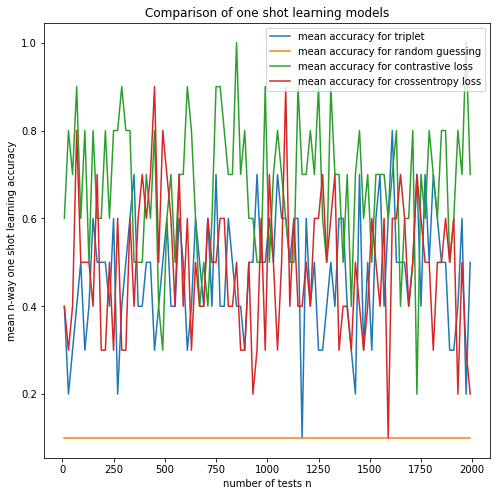

In [99]:
plt.figure(figsize = (8,8))

plt.plot(nb,acc_triplet,label='mean accuracy for triplet')
plt.plot(nb,[0.1]*len(nb), label = 'mean accuracy for random guessing')
plt.plot(nb,acc_contrastive,label='mean accuracy for contrastive loss')
plt.plot(nb,acc_binary,label='mean accuracy for crossentropy loss')
plt.xlabel('number of tests n')
plt.ylabel('mean n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

In [98]:
np.mean(acc_triplet), np.mean(acc_contrastive), np.mean(acc_binary)

(0.47600000000000003, 0.671, 0.48900000000000005)

Illustration of one pass of n way one shot learning

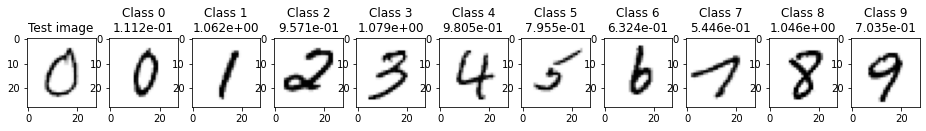

In [109]:
one_way_one_shotlearning (base_network_contrastive, all_train, all_test , 'contrastive',size_of_encoding_contrastive)